# Q-Learning experiment runner

## Imports

In [1]:
%%capture
!pip install tqdm

In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")

from tqdm import tqdm
import numpy as np
import pandas as pd
from datetime import datetime

In [3]:
from q_maze import QMaze, Action
from e_greedy_policy import EGreedyPolicy
from qlearning import QLearning

from qlearning_exp_functions import Results, train_ql_for_one_episode, run_ql_experiments, train_on_qlearning
from utils import stringify_dict, preprocess_hyperparameters_filename


## Smoke test for QMaze, EGreedyPolicy and running on one episode

In [5]:
qm = QMaze(10)
# Reminder that QMaze.reset only returns agent state now.
# Be careful to capture the state when resetting, because the 
# Agent/entrance will move!
state = qm.reset()
eg_policy = EGreedyPolicy(epsilon=0.5, decay=0.9)
ql = QLearning(policy=eg_policy, environment=qm, gamma=0.9, alpha=0.01)


In [6]:
qm.display(debug=True)

X X X X X X X X X X 
X . X . X . X A X X 
X . X . . . . . . X 
X . X X X . X X . X 
X . X . X . . X . X 
X . . . . . X X X X 
X . X . X . . X X X 
X . X . X . X X . X 
X . X . X . . . . X 
X X X X X X X X O X 

{'maze_width': 10, 'maze_height': 10, 'size': 10, 'has_treasure': False, 'treasure_found': 0, 'treasure_left': 0, 'treasure_map': [], 'position_agent': (1, 7), 'position_entrance': (1, 7), 'position_exit': (9, 8), 'maze': array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 0, 1, 0, 1, 0, 1, 2, 1, 1],
       [1, 0, 1, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 1, 1, 1, 0, 1, 1, 0, 1],
       [1, 0, 1, 0, 1, 0, 0, 1, 0, 1],
       [1, 0, 0, 0, 0, 0, 1, 1, 1, 1],
       [1, 0, 1, 0, 1, 0, 0, 1, 1, 1],
       [1, 0, 1, 0, 1, 0, 1, 1, 0, 1],
       [1, 0, 1, 0, 1, 0, 0, 0, 0, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 3, 1]]), 'generation_start_coords': (4, 1), 'generation_start_neighbours': [], 'turns_elapsed': 0, 'done': False, 'coord_to_index_state': array([[61, 35,  6, 79, 98, 84, 28, 30, 96, 33

### One iteration to check policy is working with QLearning

557
-2569


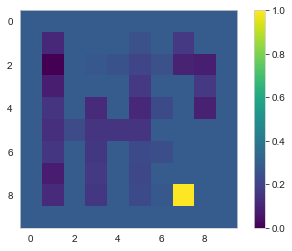

In [7]:
done = False
total_reward = 0

while not done:
    next_action = eg_policy(state, ql.q_value_store)
    next_state, reward, done = qm.step(next_action)
    next_action_index = next_action.value.index
    
    ql.update_q_values(
        current_state=state,
        next_action=next_action_index,
        next_reward=reward,
        next_state=next_state
    )

    eg_policy.update_epsilon()
    state = next_state
    total_reward += reward

print(qm.turns_elapsed)
print(total_reward)
vals = ql.display_q_values()
plt.imshow((vals - vals.min())/(vals.max() - vals.min()), cmap="viridis")
plt.colorbar()
plt.grid(False)
plt.show();

In [8]:
# The maze is solved
qm.display()

X X X X X X X X X X 
X . X . X . X I X X 
X . X . . . . . . X 
X . X X X . X X . X 
X . X . X . . X . X 
X . . . . . X X X X 
X . X . X . . X X X 
X . X . X . X X . X 
X . X . X . . . . X 
X X X X X X X X A X 



## Run for more episodes

Parameterise:
- epsilon for e-greedy
- gamma - discount factor
- alpha - learning rate or memory
- size of maze
- max reward
- decay - constant decay of epsilon

In [4]:
# Some plotting functions which must live here
# because of notebook functionality.
def plot_mean_rewards_episodes(episode_idx: int, experiment_mean_rewards: list):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title(f"Last mean reward of {experiment_mean_rewards[-1]} after {episode_idx} episodes")
    plt.xlabel("Per 100 episodes")
    plt.ylabel("Mean reward")
    plt.plot(experiment_mean_rewards)
    plt.show()

def plot_turns_elapsed_episodes(episode_idx: int, experiment_mean_turns_elapsed: list):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title(f"Last turns elapsed of {experiment_mean_turns_elapsed[-1]} after {episode_idx} episodes")
    plt.xlabel("Per 100 episodes")
    plt.ylabel("Mean turns elapsed")
    plt.plot(experiment_mean_turns_elapsed)
    plt.show()

In [4]:
# Logging stuff
RESULTS_PATH = "results"
dt_now = datetime.now()
dt_str = dt_now.strftime("%Y%m%d-%H%M%S")

OUTPUT_PATH = os.path.join(RESULTS_PATH, dt_str)

if not os.path.isdir(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)
    
LOGGING_STEP_SIZE: int = 10
NUM_EPISODES: int = 1000
NUM_RUNS: int = 100
NUM_RUNS_TQDM = tqdm(range(NUM_RUNS))
NUM_LOGGED_EPISODES: int = NUM_EPISODES//LOGGING_STEP_SIZE

ENV_SIZE_LIST = [10]
EPSILON_LIST = [0.6, 0.7, 0.8]
DECAY_LIST = [0.9, 0.8, 0.7]
GAMMA_LIST = [0.9, 0.8, 0.7]
ALPHA_LIST = [0.01, 0.02, 0.03]

for env_size in ENV_SIZE_LIST:
    for epsilon in EPSILON_LIST:
        for decay in DECAY_LIST:
            for gamma in GAMMA_LIST:
                for alpha in ALPHA_LIST:
                    train_on_qlearning(
                        env_size=env_size,
                        epsilon=epsilon,
                        decay=decay,
                        gamma=gamma,
                        alpha=alpha,
                        num_runs_tqdm=NUM_RUNS_TQDM,
                        logging_step_size=LOGGING_STEP_SIZE,
                        num_logged_episodes=NUM_LOGGED_EPISODES,
                        num_episodes=NUM_EPISODES,
                        output_path=OUTPUT_PATH
                    )



  0%|          | 0/100 [00:07<?, ?it/s]


KeyboardInterrupt: 

## Teach QMaze of different environment sizes

 71%|███████   | 71/100 [00:03<00:00, 33.14it/s]Run: 60, ending epsilon: 0.08235429999999996, mean reward: 10.156, mean turns elapsed: 4.726, std reward: 10.36395986097978
Run: 70, ending epsilon: 0.08235429999999996, mean reward: 9.89, mean turns elapsed: 4.758, std reward: 9.984883574684282
100%|██████████| 100/100 [00:03<00:00, 28.97it/s]Run: 80, ending epsilon: 0.08235429999999996, mean reward: 9.942, mean turns elapsed: 4.734, std reward: 9.32301646464276
Run: 90, ending epsilon: 0.08235429999999996, mean reward: 10.384, mean turns elapsed: 4.7, std reward: 9.668740559142126



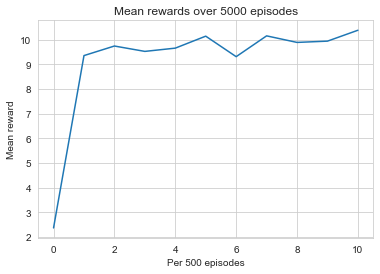

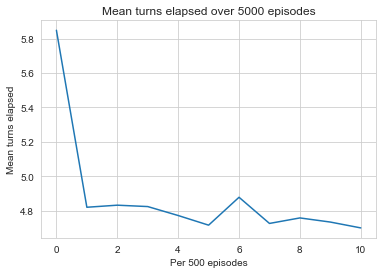

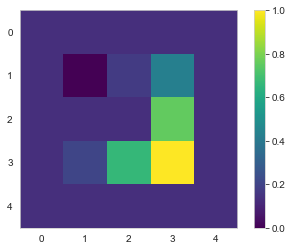

Run: 0, ending epsilon: 0.08235429999999996, mean reward: -303.886, mean turns elapsed: 93.706, std reward: 612.399693830753
Run: 1, ending epsilon: 0.08235429999999996, mean reward: 0.668, mean turns elapsed: 28.288, std reward: 80.93603508944578
Run: 10, ending epsilon: 0.08235429999999996, mean reward: 24.576, mean turns elapsed: 21.464, std reward: 49.75673043920792
Run: 20, ending epsilon: 0.08235429999999996, mean reward: 30.452, mean turns elapsed: 20.228, std reward: 22.107186523843325
Run: 30, ending epsilon: 0.08235429999999996, mean reward: 30.458, mean turns elapsed: 20.04, std reward: 23.334357415622144
Run: 40, ending epsilon: 0.08235429999999996, mean reward: 30.696, mean turns elapsed: 20.11, std reward: 22.235817592344116
Run: 50, ending epsilon: 0.08235429999999996, mean reward: 31.044, mean turns elapsed: 20.262, std reward: 22.36859548563566
Run: 60, ending epsilon: 0.08235429999999996, mean reward: 31.028, mean turns elapsed: 20.16, std reward: 21.469308698698242
R

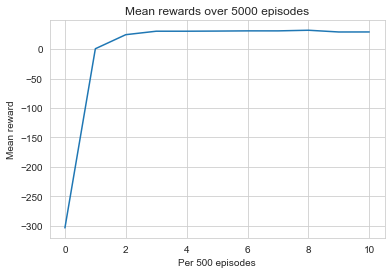

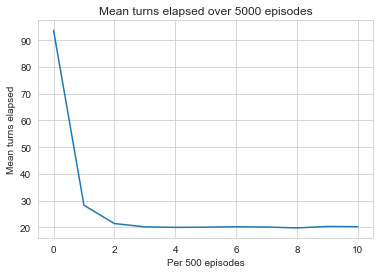

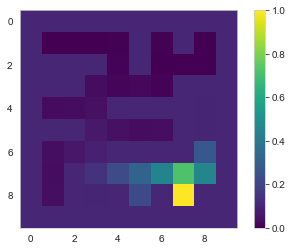

Run: 0, ending epsilon: 0.08235429999999996, mean reward: -11702.262, mean turns elapsed: 3492.002, std reward: 51815.87304370501
Run: 1, ending epsilon: 0.08235429999999996, mean reward: -26761.566, mean turns elapsed: 8099.112, std reward: 49841.89480416694
Run: 10, ending epsilon: 0.08235429999999996, mean reward: -29320.938, mean turns elapsed: 8877.824, std reward: 60815.053974605304
Run: 20, ending epsilon: 0.08235429999999996, mean reward: -32792.44, mean turns elapsed: 9921.066, std reward: 56782.53348467643
Run: 30, ending epsilon: 0.08235429999999996, mean reward: -7421.59, mean turns elapsed: 2297.318, std reward: 19446.677190561375
Run: 40, ending epsilon: 0.08235429999999996, mean reward: -3524.466, mean turns elapsed: 1125.074, std reward: 9853.930003041629
Run: 50, ending epsilon: 0.08235429999999996, mean reward: -3709.296, mean turns elapsed: 1182.828, std reward: 9464.030227360012
Run: 60, ending epsilon: 0.08235429999999996, mean reward: -5294.484, mean turns elapsed

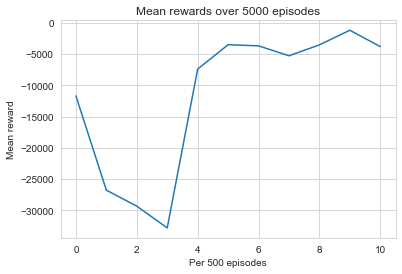

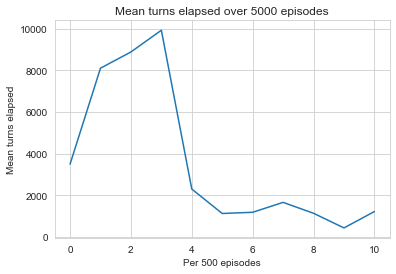

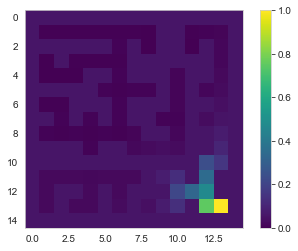

Run: 0, ending epsilon: 0.08235429999999996, mean reward: -5799.076, mean turns elapsed: 1686.96, std reward: 19612.754396112345
Run: 1, ending epsilon: 0.08235429999999996, mean reward: -10718.92, mean turns elapsed: 3314.698, std reward: 38046.72439894925
Run: 10, ending epsilon: 0.08235429999999996, mean reward: -14009.494, mean turns elapsed: 4288.416, std reward: 104723.22376929563
Run: 20, ending epsilon: 0.08235429999999996, mean reward: -8879.83, mean turns elapsed: 2764.28, std reward: 43581.748844637936
Run: 30, ending epsilon: 0.08235429999999996, mean reward: -14704.988, mean turns elapsed: 4497.61, std reward: 78900.33635778655
Run: 40, ending epsilon: 0.08235429999999996, mean reward: -13910.156, mean turns elapsed: 4271.822, std reward: 67544.04780573685
Run: 50, ending epsilon: 0.08235429999999996, mean reward: -7447.096, mean turns elapsed: 2331.01, std reward: 43802.39282626902
Run: 60, ending epsilon: 0.08235429999999996, mean reward: -11731.78, mean turns elapsed: 3

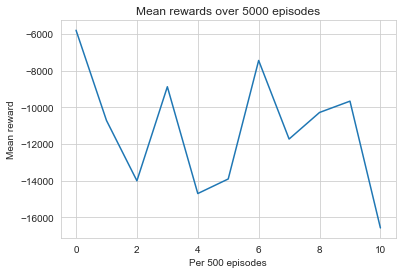

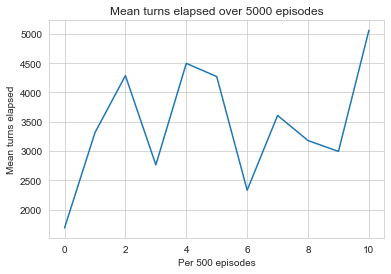

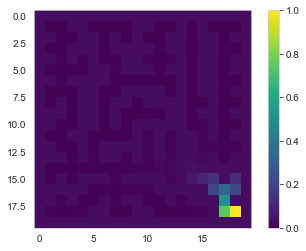

Run: 0, ending epsilon: 0.08235429999999996, mean reward: -211416.918, mean turns elapsed: 62980.686, std reward: 2161609.4589960002


KeyboardInterrupt: 

In [4]:
# Logging stuff
RESULTS_PATH = "results"
dt_now = datetime.now()
dt_str = dt_now.strftime("%Y%m%d-%H%M%S")

OUTPUT_PATH = os.path.join(RESULTS_PATH, dt_str)

if not os.path.isdir(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)
    
LOGGING_STEP_SIZE: int = 10
NUM_EPISODES: int = 5000 # Upped this to 5000
NUM_RUNS: int = 100
NUM_RUNS_TQDM = tqdm(range(NUM_RUNS))
NUM_LOGGED_EPISODES: int = NUM_EPISODES//LOGGING_STEP_SIZE

ENV_SIZE_LIST = [5, 10, 15, 20, 25, 30]
EPSILON_LIST = [0.7]
DECAY_LIST = [0.7]
GAMMA_LIST = [0.7]
ALPHA_LIST = [0.01]

for env_size in ENV_SIZE_LIST:
    for epsilon in EPSILON_LIST:
        for decay in DECAY_LIST:
            for gamma in GAMMA_LIST:
                for alpha in ALPHA_LIST:
                    train_on_qlearning(
                        env_size=env_size,
                        epsilon=epsilon,
                        decay=decay,
                        gamma=gamma,
                        alpha=alpha,
                        num_runs_tqdm=NUM_RUNS_TQDM,
                        logging_step_size=LOGGING_STEP_SIZE,
                        num_logged_episodes=NUM_LOGGED_EPISODES,
                        num_episodes=NUM_EPISODES,
                        output_path=OUTPUT_PATH
                    )